In [ ]:
import librosa
import soundfile
import os, glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn import preprocessing 
from sklearn.metrics import roc_auc_score

# Emotions in the dataset



emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

# Audio Feature extraction 

In [19]:
def extract_feature(file_name, mfcc, chroma,spectral_centroid,spectral_bandwidth,spectral_rolloff,spectral_contrast,rms,spectral_flatness):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
            
            
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))             
           
            
        if spectral_centroid:
            spectral_centroid=np.mean(librosa.feature.spectral_centroid(y=X, sr=sample_rate))
            result=np.hstack((result, spectral_centroid)) 
        
        if spectral_bandwidth:
           spectral_bandwidth=np.mean(librosa.feature.spectral_bandwidth(y=X, sr=sample_rate).T)
#           print(spectral_bandwidth)
           result=np.hstack((result, spectral_bandwidth)) 
           
        if spectral_rolloff:
           spectral_rolloff=np.mean(librosa.feature.spectral_rolloff(y=X, sr=sample_rate).T)
#           print(spectral_rolloff)
           result=np.hstack((result, spectral_rolloff))
        
        if spectral_contrast:
           spectral_contrast=np.mean(librosa.feature.spectral_contrast(y=X, sr=sample_rate))
           result=np.hstack((result, spectral_contrast))
           
        if rms:
           rms=np.mean(librosa.feature.rms(y=X).T,axis=0)
           result=np.hstack((result, rms))
           
        if spectral_flatness:
           spectral_flatness=np.mean(librosa.feature.spectral_flatness(y=X))
           result=np.hstack((result, spectral_flatness))
        
        return result

# feature extraction from audio files

In [13]:
################### feature extraction by calling the files ############################

def load_data():
    X,y=[],[]
    for file in glob.glob("D:\\DBDA\\speech-emotion-recognition-ravdess-data\\Actor_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        feature=extract_feature(file, mfcc=True, chroma=True,spectral_centroid=True,spectral_bandwidth=True,spectral_rolloff=True,spectral_contrast=True,rms=True,spectral_flatness=True)
        X.append(feature)
        y.append(emotion)
        
    return X,y

# Data Preprocessing


X_audio,y_emotions=load_data()

features=[]
for i in range(1,59) :
    features.append("feat"+str(i))    


le = preprocessing.LabelEncoder()
y1=le.fit_transform(y_emotions)


X1=pd.DataFrame(X_audio,columns=features)
y=pd.DataFrame(y1,columns=["emotions"])
X=X1.drop(["feat1"],axis=1)
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.1, random_state=2019,stratify=y) 

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train_scaled=scaler.fit_transform(x_train)
x_train_scaled = pd.DataFrame(x_train_scaled,index=x_train.index,columns=x_train.columns)



# Scree Plot to decide number of clusters

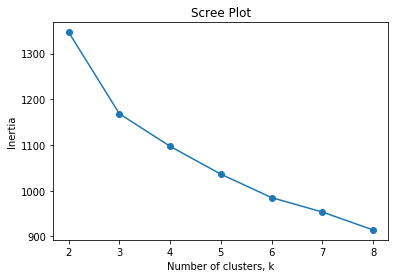

In [18]:

######################################## scree plot to determine number of clusters #########################


from sklearn.cluster import MiniBatchKMeans

clustNos = [2,3,4,5,6,7,8]
Inertia = []

for i in clustNos :
    model = MiniBatchKMeans(n_clusters=i,random_state=2019)
    model.fit(x_train_scaled)
    Inertia.append(model.inertia_)
    
# Import pyplot
import matplotlib.pyplot as plt

plt.plot(clustNos, Inertia, '-o')
plt.title("Scree Plot")
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(clustNos)
plt.show()


# training K means clusering for K=3

In [20]:
model_km= MiniBatchKMeans(n_clusters=3,random_state=2019,n_init=20)
model_km.fit(x_train_scaled)
ClusterID = model_km.predict(x_train_scaled)
ClusterID = pd.DataFrame(ClusterID,index=x_train.index,columns=["Cluster"])
Clust_x_train = pd.concat([ClusterID,y_train,x_train],axis="columns")

Clust0 = Clust_x_train[Clust_x_train['Cluster']==0]
Clust1 = Clust_x_train[Clust_x_train['Cluster']==1]
Clust2 = Clust_x_train[Clust_x_train['Cluster']==2]


print(Clust0.shape)
print(Clust1.shape)
print(Clust2.shape)

(337, 59)
(425, 59)
(480, 59)


#   applying Supervised Learning models on each clusters

In [24]:
###################################  train cluster 0 ##################################

from sklearn.ensemble import GradientBoostingClassifier

Clust0["emotions"].value_counts()
X0 = Clust0.iloc[:,2:]
y0 = Clust0["emotions"]

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size = 0.2,                                                  random_state=2019,
                                                   stratify=y0)

# Training Cluster 0 with GradientBoosting

In [25]:
############################### scaling the input data ####################

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X0_train_scaled=scaler.fit_transform(X0_train)

X0_train_scaled = pd.DataFrame(X0_train_scaled,
                          columns=X0_train.columns,
                          index=X0_train.index)



In [ ]:
 ############## set tuning parameters #####################
    
lr_range = np.linspace(0.001,1,30)
n_est_range = np.arange(10,200,20)
depth_range = np.arange(5,50,5)
minleaf_range = np.arange(10,50,10)

parameters = dict(learning_rate=lr_range,              
                  max_depth=depth_range,
                  min_samples_leaf=minleaf_range)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

kfold = StratifiedKFold(n_splits=5, random_state=42)
clf = GradientBoostingClassifier(random_state=2019)
gb0 = RandomizedSearchCV(clf, param_distributions=parameters,cv=kfold,scoring='neg_log_loss',verbose=3,n_jobs=-1)
gb0.fit(X0_train,y0_train)
X0_test.reset_index(drop=True)
y0_pred0_proba_gb=gb0.predict_proba(X0_test)

    
print("ROC_auc_score for Gradient Boost:\n",roc_auc_score(y0_test, y0_pred0_proba_gb,multi_class='ovr'))

print(gb0.best_params_)

print("loss for Gradient Boost Model",gb0.best_score_)


#print(y0_test.value_counts())
#print(y0_pred0_proba_gb)


# Training Cluster 0 with Random forest

In [27]:
################### Random Forest ###############

n_est_range = np.arange(10,200,20)
depth_range = np.arange(5,50,5)
max_feat_range = np.arange(20,52)
minleaf_range = np.arange(10,50,10)
minsplit_range = np.arange(5,50,5)

parameters = dict(n_estimators=n_est_range,
                  max_depth=depth_range,
                  min_samples_split=minsplit_range,
                  min_samples_leaf=minleaf_range,
                  max_features=max_feat_range)

from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state=2019)

rf0 = RandomizedSearchCV(model_rf, param_distributions =parameters,
                  cv=kfold,scoring='neg_log_loss',verbose=3,n_iter=100,n_jobs=-1)

rf0.fit(X0_train,y0_train)


print(rf0.best_params_)

print(rf0.best_score_)

y_pred0_proba_RF=rf0.predict_proba(X0_test)

print("ROC_AUC rf",roc_auc_score(y0_test, y_pred0_proba_RF, multi_class='ovr'))   


#ROC_AUC rf 0.8043857854147589

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 429 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   10.7s finished


{'n_estimators': 170, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 51, 'max_depth': 10}
-1.5618877510103588
ROC_AUC rf 0.8043857854147589


# Training Cluster 0 with XGBoost

In [28]:
#############################################################################

from xgboost import XGBClassifier

lr_range = [0.001, 0.01, 0.1, 0.2,0.25, 0.3]
n_est_range = [10,20,30,50,100,120,150]
md_range = [2,4,6,8,10]



parameters = dict(learning_rate=lr_range,n_estimators=n_est_range, max_depth=md_range)

from sklearn.model_selection import RandomizedSearchCV
clf = XGBClassifier(random_state=2019)
xgb0 = RandomizedSearchCV(clf, param_distributions=parameters,cv=5,scoring='neg_log_loss',verbose=3)
xgb0.fit(X0_train,y0_train)
print(xgb0.best_score_)
print(xgb0.best_params_)
y_pred0_proba=xgb0.predict_proba(X0_test)
print("ROC_AUC rf",roc_auc_score(y0_test, y_pred0_proba, multi_class='ovr'))   

#ROC_AUC rf 0.8448378631904228

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=120, max_depth=8, learning_rate=0.001 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=120, max_depth=8, learning_rate=0.001, score=-2.029, total=   2.0s
[CV] n_estimators=120, max_depth=8, learning_rate=0.001 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  n_estimators=120, max_depth=8, learning_rate=0.001, score=-2.034, total=   2.0s
[CV] n_estimators=120, max_depth=8, learning_rate=0.001 ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[CV]  n_estimators=120, max_depth=8, learning_rate=0.001, score=-1.984, total=   1.9s
[CV] n_estimators=120, max_depth=8, learning_rate=0.001 ..............
[CV]  n_estimators=120, max_depth=8, learning_rate=0.001, score=-2.029, total=   1.9s
[CV] n_estimators=120, max_depth=8, learning_rate=0.001 ..............
[CV]  n_estimators=120, max_depth=8, learning_rate=0.001, score=-1.988, total=   1.9s
[CV] n_estimators=150, max_depth=10, learning_rate=0.1 ...............
[CV]  n_estimators=150, max_depth=10, learning_rate=0.1, score=-1.557, total=   1.4s
[CV] n_estimators=150, max_depth=10, learning_rate=0.1 ...............
[CV]  n_estimators=150, max_depth=10, learning_rate=0.1, score=-1.622, total=   1.4s
[CV] n_estimators=150, max_depth=10, learning_rate=0.1 ...............
[CV]  n_estimators=150, max_depth=10, learning_rate=0.1, score=-1.296, total=   1.5s
[CV] n_estimators=150, max_depth=10, learning_rate=0.1 ...............
[CV]  n_estimators=150, max_depth=10, learning_rate=0.1, scor

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.3s finished


-1.4891564747031614
{'n_estimators': 120, 'max_depth': 10, 'learning_rate': 0.1}
ROC_AUC rf 0.8448378631904228


In [29]:
########################################### MultinomialNB #####################################################


from sklearn.naive_bayes import MultinomialNB

multinomial = MultinomialNB()

mul=multinomial.fit(X0_train_scaled, y0_train) # Model Building
y_pred0_proba_mul=mul.predict_proba(X0_test)
print("ROC_AUC rf",roc_auc_score(y0_test, y_pred0_proba_mul, multi_class='ovr'))   
#ROC_AUC rf 0.49645255390834864

ROC_AUC rf 0.49645255390834864


In [ ]:
##############################################  MLP ##########################################


lr_range = np.linspace(0.01,0.8,10)
hl_range = [(400,200,150,200,250,100,300)]
act_range = ['logistic','tanh','sigmoid']
parameters = dict(learning_rate_init=lr_range,hidden_layer_sizes = hl_range,
                  activation = act_range)

mlp=MLPClassifier()
model_mlp=RandomizedSearchCV(clf, param_distributions=parameters,cv=5,scoring='neg_log_loss',verbose=3)
model_mlp.fit(X0_train_scaled, y0_train)

y_pred0_proba_mlp=mul.predict_proba(X0_test)

print(model_mlp.best_score_)
print(model_mlp.best_params_)

print("ROC_AUC rf",roc_auc_score(y0_test, y_pred0_proba_mlp, multi_class='ovr'))  

#ROC_AUC rf 0.49645255390834864

# Training Cluster 1 with GradientBoosting

In [32]:
#################################### train cluster 1 ##################################



Clust1["emotions"].value_counts()
X1 = Clust1.iloc[:,2:]
y1 = Clust1["emotions"]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2,                                                  random_state=2019,
                                                   stratify=y1)


In [33]:
############################### scaling the input data ####################

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X1_train_scaled=scaler.fit_transform(X1_train)

X1_train_scaled = pd.DataFrame(X1_train_scaled,
                          columns=X1_train.columns,
                          index=X1_train.index)


lr_range = np.linspace(0.001,1,30)
n_est_range = np.arange(10,50,20)
depth_range = np.arange(5,50,5)
minleaf_range = np.arange(10,50,10)

parameters = dict(learning_rate=lr_range,              
                  max_depth=depth_range,
                  min_samples_leaf=minleaf_range,n_estimators=n_est_range )

kfold = StratifiedKFold(n_splits=5, random_state=42)
GB1 = GradientBoostingClassifier(random_state=2019)
model_GB1 = RandomizedSearchCV(GB1, param_distributions=parameters,cv=kfold,scoring='neg_log_loss',verbose=3,n_jobs=-1)
model_GB1.fit(X1_train,y1_train)
X1_test.reset_index(drop=True)
y1_pred1_proba_GB=model_GB1.predict_proba(X1_test)
#y0_pred0_proba1=pd.DataFrame(y0_pred0_proba1)
#y0_pred0_proba_em=y0_pred0_proba1.idxmax(axis=1)
#y0_pred0_proba=y0_pred0_proba1.max(axis=1)
#y0_pred0_proba3=pd.DataFrame(y0_pred0_proba)
#y0_test1=pd.DataFrame(y0_test)
#def fun():
#    global y0_pred0_proba1
#    print("test")
#    for i,row in y0_pred0_proba1.iterrows():    
#        c=(max(row))
#        print (c)
    
print("ROC_auc_score for Gradient Boost:\n",roc_auc_score(y1_test, y1_pred1_proba_GB,multi_class='ovr'))

print(model_GB1.best_params_)

print("loss for Gradient Boost Model",model_GB1.best_score_)

print(y1_test.value_counts())


#ROC_auc_score for Gradient Boost: 0.8100625720044856
#{'n_estimators': 30, 'min_samples_leaf': 30, 'max_depth': 40, 'learning_rate': 0.24213793103448275}


C:\Users\dai\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  36 out of  50 | elapsed:    4.7s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.9s finished


ROC_auc_score for Gradient Boost:
 0.8100625720044856
{'n_estimators': 30, 'min_samples_leaf': 30, 'max_depth': 40, 'learning_rate': 0.24213793103448275}
loss for Gradient Boost Model -1.57155940039346
1    17
2    14
6    13
7    10
4     9
5     8
3     7
0     7
Name: emotions, dtype: int64


# Training Cluster 1 with Random Forest

In [35]:
################### Random Forest ###############


n_est_range = np.arange(10,200,20)
depth_range = np.arange(5,50,5)
max_feat_range = np.arange(20,57)
minleaf_range = np.arange(10,50,10)
minsplit_range = np.arange(5,50,5)

parameters = dict(n_estimators=n_est_range,
                  max_depth=depth_range,
                  min_samples_split=minsplit_range,
                  min_samples_leaf=minleaf_range,
                  max_features=max_feat_range)

from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier(random_state=2019)

model_rf1 = RandomizedSearchCV(rf1, param_distributions =parameters,
                  cv=kfold,scoring='neg_log_loss',verbose=3,n_iter=100,n_jobs=-1)

model_rf1.fit(X1_train,y1_train)


print(model_rf1.best_params_)

print(model_rf1.best_score_)

y_pred1_proba_RF=model_rf1.predict_proba(X1_test)

print("ROC_AUC rf",roc_auc_score(y1_test, y_pred1_proba_RF, multi_class='ovr'))   

#{'n_estimators': 190, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 50, 'max_depth': 30}
#-1.643701330257354
#ROC_AUC rf 0.7916737542025991


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   13.3s finished


{'n_estimators': 190, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 50, 'max_depth': 30}
-1.643701330257354
ROC_AUC rf 0.7916737542025991


# Training Cluster 1 with XGBoost

In [37]:
###################################   XGBoost   ##########################################

lr_range = [0.001, 0.01, 0.1, 0.2,0.25, 0.3]
n_est_range = [10,20,30,50,100,120,150]
md_range = [2,4,6,8,10]

parameters = dict(learning_rate=lr_range,n_estimators=n_est_range, max_depth=md_range)

from sklearn.model_selection import RandomizedSearchCV
XGB1 = XGBClassifier(random_state=2019)
model_XGB1 = RandomizedSearchCV(XGB1, param_distributions=parameters,cv=5,scoring='neg_log_loss',verbose=3)
model_XGB1.fit(X1_train,y1_train)
print(model_XGB1.best_score_)
print(model_XGB1.best_params_)
y_pred1_proba_XGB=model_XGB1.predict_proba(X1_test)
print("ROC_AUC ",roc_auc_score(y1_test, y_pred1_proba_XGB, multi_class='ovr'))   

#-1.488675482467036
#{'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1}
#ROC_AUC  0.8248853363080373

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=100, max_depth=2, learning_rate=0.1 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, max_depth=2, learning_rate=0.1, score=-1.476, total=   0.9s
[CV] n_estimators=100, max_depth=2, learning_rate=0.1 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=100, max_depth=2, learning_rate=0.1, score=-1.567, total=   0.9s
[CV] n_estimators=100, max_depth=2, learning_rate=0.1 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=100, max_depth=2, learning_rate=0.1, score=-1.559, total=   0.9s
[CV] n_estimators=100, max_depth=2, learning_rate=0.1 ................
[CV]  n_estimators=100, max_depth=2, learning_rate=0.1, score=-1.688, total=   0.8s
[CV] n_estimators=100, max_depth=2, learning_rate=0.1 ................
[CV]  n_estimators=100, max_depth=2, learning_rate=0.1, score=-1.524, total=   0.9s
[CV] n_estimators=20, max_depth=2, learning_rate=0.3 .................
[CV]  n_estimators=20, max_depth=2, learning_rate=0.3, score=-1.537, total=   0.2s
[CV] n_estimators=20, max_depth=2, learning_rate=0.3 .................
[CV]  n_estimators=20, max_depth=2, learning_rate=0.3, score=-1.627, total=   0.2s
[CV] n_estimators=20, max_depth=2, learning_rate=0.3 .................
[CV]  n_estimators=20, max_depth=2, learning_rate=0.3, score=-1.581, total=   0.2s
[CV] n_estimators=20, max_depth=2, learning_rate=0.3 .................
[CV]  n_estimators=20, max_depth=2, learning_rate=0.3, score=-1.755, tota

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   44.2s finished


-1.506646456405082
{'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.1}
ROC_AUC  0.8238605870323328


# Training Cluster 2 with Gradient Boosting

In [38]:
########################################################################################
#################################### train cluster 2 ##################################



Clust1["emotions"].value_counts()
X2 = Clust2.iloc[:,2:]
y2 = Clust2["emotions"]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2,                                                  random_state=2019,
                                                   stratify=y2)

In [40]:
############################### scaling the input data ####################

X2_train_scaled=scaler.fit_transform(X2_train)

X2_train_scaled = pd.DataFrame(X2_train_scaled,
                          columns=X2_train.columns,
                          index=X2_train.index)


lr_range = np.linspace(0.001,1,30)
n_est_range = np.arange(10,50,20)
depth_range = np.arange(5,50,5)
minleaf_range = np.arange(10,50,10)

parameters = dict(learning_rate=lr_range,              
                  max_depth=depth_range,
                  min_samples_leaf=minleaf_range,n_estimators=n_est_range )

kfold = StratifiedKFold(n_splits=5, random_state=42)
GB2 = GradientBoostingClassifier(random_state=2019)
model_GB2 = RandomizedSearchCV(GB2, param_distributions=parameters,cv=kfold,scoring='neg_log_loss',verbose=3,n_jobs=-1)
model_GB2.fit(X2_train,y2_train)
X2_test.reset_index(drop=True)
y_pred2_proba_GB=model_GB2.predict_proba(X2_test)

print("ROC_auc_score for Gradient Boost:\n",roc_auc_score(y2_test, y_pred2_proba_GB,multi_class='ovr'))

print(model_GB2.best_params_)

print("loss for Gradient Boost Model",model_GB2.best_score_)

print(y2_test.value_counts())

#ROC_auc_score for Gradient Boost: 0.8586810276321564
#{'n_estimators': 30, 'min_samples_leaf': 20, 'max_depth': 40, 'learning_rate': 0.06989655172413793}

C:\Users\dai\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  36 out of  50 | elapsed:    3.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.8s finished


ROC_auc_score for Gradient Boost:
 0.8586810276321564
{'n_estimators': 30, 'min_samples_leaf': 20, 'max_depth': 40, 'learning_rate': 0.06989655172413793}
loss for Gradient Boost Model -1.3405080848187516
0    19
3    18
7    14
4    14
6    11
2    10
1     7
5     3
Name: emotions, dtype: int64


# Training Cluster 2 with Random Forest

In [41]:
################### Random Forest ###############


n_est_range = np.arange(10,200,20)
depth_range = np.arange(5,50,5)
max_feat_range = np.arange(20,57)
minleaf_range = np.arange(10,50,10)
minsplit_range = np.arange(5,50,5)

parameters = dict(n_estimators=n_est_range,
                  max_depth=depth_range,
                  min_samples_split=minsplit_range,
                  min_samples_leaf=minleaf_range,
                  max_features=max_feat_range)

from sklearn.ensemble import RandomForestClassifier
rf2 = RandomForestClassifier(random_state=2019)

model_rf2 = RandomizedSearchCV(rf2, param_distributions =parameters,
                  cv=kfold,scoring='neg_log_loss',verbose=3,n_iter=100,n_jobs=-1)

model_rf2.fit(X2_train,y2_train)


print(model_rf2.best_params_)

print(model_rf2.best_score_)

y_pred2_proba_RF=model_rf2.predict_proba(X2_test)

print("ROC_AUC rf",roc_auc_score(y2_test, y_pred2_proba_RF, multi_class='ovr'))   

#{'n_estimators': 190, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 48, 'max_depth': 10}
#-1.3959358272271494
#ROC_AUC rf 0.8626562341030408


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 318 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.2s finished


{'n_estimators': 190, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 48, 'max_depth': 10}
-1.3959358272271494
ROC_AUC rf 0.8626562341030408


# Training Cluster 2 with XGBoost

In [42]:
###################################   XGBoost   ##########################################

lr_range = [0.001, 0.01, 0.1, 0.2,0.25, 0.3]
n_est_range = [10,20,30,50,100,120,150]
md_range = [2,4,6,8,10]

parameters = dict(learning_rate=lr_range,n_estimators=n_est_range, max_depth=md_range)

from sklearn.model_selection import RandomizedSearchCV
XGB2 = XGBClassifier(random_state=2019)
model_XGB2 = RandomizedSearchCV(XGB1, param_distributions=parameters,cv=5,scoring='neg_log_loss',verbose=3)
model_XGB2.fit(X2_train,y2_train)
print(model_XGB2.best_score_)
print(model_XGB2.best_params_)
y_pred2_proba_XGB=model_XGB2.predict_proba(X2_test)
print("ROC_AUC ",roc_auc_score(y2_test, y_pred2_proba_XGB, multi_class='ovr')) 


#-1.3149974532790962
#{'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.25}
#ROC_AUC  0.8902329566151146

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=20, max_depth=6, learning_rate=0.3 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=20, max_depth=6, learning_rate=0.3, score=-1.216, total=   0.4s
[CV] n_estimators=20, max_depth=6, learning_rate=0.3 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  n_estimators=20, max_depth=6, learning_rate=0.3, score=-1.292, total=   0.4s
[CV] n_estimators=20, max_depth=6, learning_rate=0.3 .................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  n_estimators=20, max_depth=6, learning_rate=0.3, score=-1.226, total=   0.4s
[CV] n_estimators=20, max_depth=6, learning_rate=0.3 .................
[CV]  n_estimators=20, max_depth=6, learning_rate=0.3, score=-1.638, total=   0.4s
[CV] n_estimators=20, max_depth=6, learning_rate=0.3 .................
[CV]  n_estimators=20, max_depth=6, learning_rate=0.3, score=-1.275, total=   0.4s
[CV] n_estimators=20, max_depth=10, learning_rate=0.25 ...............
[CV]  n_estimators=20, max_depth=10, learning_rate=0.25, score=-1.217, total=   0.5s
[CV] n_estimators=20, max_depth=10, learning_rate=0.25 ...............
[CV]  n_estimators=20, max_depth=10, learning_rate=0.25, score=-1.336, total=   0.5s
[CV] n_estimators=20, max_depth=10, learning_rate=0.25 ...............
[CV]  n_estimators=20, max_depth=10, learning_rate=0.25, score=-1.246, total=   0.5s
[CV] n_estimators=20, max_depth=10, learning_rate=0.25 ...............
[CV]  n_estimators=20, max_depth=10, learning_rate=0.25, score=-1.573,

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   38.3s finished


-1.3149974532790962
{'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.25}
ROC_AUC  0.8902329566151146


# VALIDATION DATASET

In [74]:
##################################################  TESTING ##############################################

X_test_scaled=scaler.transform(x_test)

ClusterID = model_km.predict(X_test_scaled)
ClusterID = pd.DataFrame(ClusterID,index=x_test.index,columns=["Cluster"])

Clust_X_test = pd.concat([ClusterID,y_test,x_test],axis="columns")



Clust0_test = Clust_X_test[Clust_X_test['Cluster']==0]
Clust1_test = Clust_X_test[Clust_X_test['Cluster']==1]
Clust2_test = Clust_X_test[Clust_X_test['Cluster']==2]
print(Clust0_test.shape)
print(Clust1_test.shape)
print(Clust2_test.shape)


##### pick the best models in each clusters
Clust0_best=gb0
Clust1_best=model_XGB1
Clust2_best=model_GB2


y_testset0 = Clust0_test["emotions"]
y_testset1 = Clust1_test["emotions"]
y_testset2 = Clust2_test["emotions"]

print(y_testset2.value_counts()) 

y_pred_test_clust0 = Clust0_best.predict_proba(Clust0_test.iloc[:,2:])

y_pred_test_clust1 = Clust1_best.predict_proba(Clust1_test.iloc[:,2:])

y_pred_test_clust2 = Clust2_best.predict_proba(Clust2_test.iloc[:,2:])

if len(y_testset1.value_counts()) < 8 :      
    
    y_testset0 = pd.DataFrame(y_testset0,index=y_testset0.index)
    y_testset1 = pd.DataFrame(y_testset1,index=y_testset1.index)
    y_testset_df=pd.concat([y_testset0,y_testset1])
    
    
    y_pred_test_clust0_df= pd.DataFrame(y_pred_test_clust0,index=Clust0_test.index)
    y_pred_test_clust1_df= pd.DataFrame(y_pred_test_clust1,index=Clust1_test.index)
    y_pred_concat_test_df=pd.concat([y_pred_test_clust0_df,y_pred_test_clust1_df])
    
elif len(y_testset2.value_counts()) < 8 :
    
    y_testset2 = pd.DataFrame(y_testset2,index=y_testset2.index)
    y_testset0 = pd.DataFrame(y_testset0,index=y_testset0.index)
    y_testset_df=pd.concat([y_testset0,y_testset2])
    
    y_pred_test_clust0_df= pd.DataFrame(y_pred_test_clust0,index=Clust0_test.index)
    y_pred_test_clust2_df= pd.DataFrame(y_pred_test_clust2,index=Clust2_test.index)
    y_pred_concat_test_df=pd.concat([y_pred_test_clust0_df,y_pred_test_clust2_df])

else:
    
    y_testset0 = pd.DataFrame(y_testset0,index=y_testset0.index)
    y_testset1 = pd.DataFrame(y_testset1,index=y_testset1.index)
    y_testset2 = pd.DataFrame(y_testset2,index=y_testset2.index)    
    y_testset_df=pd.concat([y_testset0,y_testset1,y_testset2])
    
    y_pred_test_clust0_df= pd.DataFrame(y_pred_test_clust0,index=Clust0_test.index)
    y_pred_test_clust1_df= pd.DataFrame(y_pred_test_clust1,index=Clust1_test.index)
    y_pred_test_clust2_df= pd.DataFrame(y_pred_test_clust2,index=Clust2_test.index)
    y_pred_concat_test_df=pd.concat([y_pred_test_clust0_df,y_pred_test_clust1_df,y_pred_test_clust2_df])     

#print("ROC_AUC ",roc_auc_score(y_testset0,y_pred_test_clust0, multi_class='ovr'))  
#ROC_AUC  0.8447395777744287


#print("ROC_AUC ",roc_auc_score(y_testset1,y_pred_test_clust1, multi_class='ovr'))  
#ROC_AUC  0.8574143005768946


#print("ROC_AUC ",roc_auc_score(y_testset2,y_pred_test_clust2, multi_class='ovr'))  


print("ROC_AUC ",roc_auc_score(y_testset_df,y_pred_concat_test_df, multi_class='ovr'))  

#ROC_AUC  0.8672289942434122

(57, 59)
(61, 59)
(20, 59)
4    5
0    5
3    4
7    2
2    2
1    2
Name: emotions, dtype: int64
ROC_AUC  0.8672289942434122


# UNSEEN DATASET 

In [73]:
ClusterID_TEST = model_km.predict(X_TEST_scaled)
ClusterID_TEST = pd.DataFrame(ClusterID_TEST,index=XT.index,columns=["Cluster"])

Clust_X_TEST = pd.concat([ClusterID_TEST,yT,XT],axis="columns")


Clust0_TEST = Clust_X_TEST[Clust_X_TEST['Cluster']==0]
Clust1_TEST = Clust_X_TEST[Clust_X_TEST['Cluster']==1]
Clust2_TEST = Clust_X_TEST[Clust_X_TEST['Cluster']==2]

y_TESTset0 = Clust0_TEST["emotions"]
y_TESTset1 = Clust1_TEST["emotions"]
y_TESTset2 = Clust2_TEST["emotions"]

y_pred_TEST_clust0 = Clust0_best.predict_proba(Clust0_TEST.iloc[:,2:])

y_TESTset0.shape

(59,)

In [72]:
############# predictions on the clusters ################

if len(y_TESTset1.value_counts()) < 8 :      
    
    y_TESTset0 = pd.DataFrame(y_TESTset0,index=y_TESTset0.index)
    y_TESTset1 = pd.DataFrame(y_TESTset1,index=y_TESTset1.index)    
    y_TESTset_df=pd.concat([y_TESTset0,y_TESTset1])
    
    y_pred_TEST_clust1 = Clust1_best.predict_proba(Clust1_TEST.iloc[:,2:])
    y_pred_TEST_clust0_df= pd.DataFrame(y_pred_TEST_clust0,index=Clust0_TEST.index)
    y_pred_TEST_clust1_df= pd.DataFrame(y_pred_TEST_clust1,index=Clust1_TEST.index) 
    y_pred_concat_TEST_df=pd.concat([y_pred_TEST_clust0_df,y_pred_TEST_clust1_df])
    
elif len(y_TESTset2.value_counts()) < 8 :    
                                                   
    y_TESTset2 = pd.DataFrame(y_TESTset2,index=y_TESTset2.index)
    y_TESTset0 = pd.DataFrame(y_TESTset0,index=y_TESTset0.index)
    y_TESTset_df=pd.concat([y_TESTset0,y_TESTset2])
    
    y_pred_TEST_clust2 = Clust2_best.predict_proba(Clust2_TEST.iloc[:,2:])
    y_pred_TEST_clust0_df= pd.DataFrame(y_pred_TEST_clust0,index=Clust0_TEST.index)
    y_pred_TEST_clust2_df= pd.DataFrame(y_pred_TEST_clust2,index=Clust2_TEST.index)
    y_pred_concat_TEST_df=pd.concat([y_pred_TEST_clust0_df,y_pred_TEST_clust2_df])

else:
    
    y_pred_TEST_clust1 = Clust1_best.predict_proba(Clust1_TEST.iloc[:,2:])
    y_pred_TEST_clust2 = Clust2_best.predict_proba(Clust2_TEST.iloc[:,2:])
    y_TESTset0 = pd.DataFrame(y_TESTset0,index=y_TESTset0.index)
    y_TESTset1 = pd.DataFrame(y_TESTset1,index=y_TESTset1.index)
    y_TESTset2 = pd.DataFrame(y_TESTset2,index=y_TESTset2.index)
    y_TESTset_df=pd.concat([y_TESTset0,y_TESTset1,y_TESTset2])
    
    y_pred_TEST_clust0_df= pd.DataFrame(y_pred_TEST_clust0,index=Clust0_TEST.index)
    y_pred_TEST_clust1_df= pd.DataFrame(y_pred_TEST_clust1,index=Clust1_TEST.index)
    y_pred_TEST_clust2_df= pd.DataFrame(y_pred_TEST_clust2,index=Clust2_TEST.index)
    
    y_pred_concat_TEST_df=pd.concat([y_pred_TEST_clust0_df,y_pred_TEST_clust1_df,y_pred_TEST_clust2_df])    
    
    


In [64]:
#print("ROC_AUC ",roc_auc_score(y_TESTset0,y_pred_TEST_clust0, multi_class='ovr'))  


#print("ROC_AUC ",roc_auc_score(y_TESTset1,y_pred_TEST_clust1, multi_class='ovr'))  


print("ROC_AUC ",roc_auc_score(y_TESTset_df,y_pred_concat_TEST_df, multi_class='ovr'))  
#ROC_AUC  0.8284254807692307


ROC_AUC  0.7937843406593406
